# Notebook 1: Opening and Visualizing FITS Files and Image Reduction

In this notebook the goal will be to become oriented with FITS files which are the fundamental file type astronomical images are stored in.

We will practice this using the JWST data that will be the foundation for this project.

## Opening the Image

Below we will import several important packages for the analysis. 

Astropy is the go-to package for all things fits files and other helpful astronomy related things.

Matplotlib is a plotting package for python you may already be acquainted with.

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sep

Here we are loading in the data for the first time. The fit.open command creates the image object. header simply access the header the of the fits file that is basically a built-in readme file that fits files have detailing the observation and various other things related to the image. data simply access the data from the image and turns it into an array. This is what we will be using for the remainder of the project. WCS stands for World Coordinate System and contains the information regarding the sky coordinates of the object, M82.

In [2]:
hdulist = fits.open("RawData/JWST_770w_IR_data.fits")
header = hdulist[1].header
imdat = hdulist[1].data
#imdat[imdat==0] = np.nan
wcs = WCS(hdulist[1].header)

Set DATE-AVG to '2023-12-31T19:43:39.963' from MJD-AVG.
Set DATE-END to '2024-01-01T01:32:08.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.864333 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694877744.107 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Now that we have our data, let us do some plotting. Below we will be using various matplotlib commmands to customize our plots. One to note is the norm parameter in the imshow command. Because objects in astronomy vary so much in brightness we put images in log scale. 

cmap simply defines the colormap you want the image to be. You can find them all here and change it if you want https://matplotlib.org/stable/users/explain/colors/colormaps.html

Change the vmin and vmax to highlight the filaments away from the disk better.

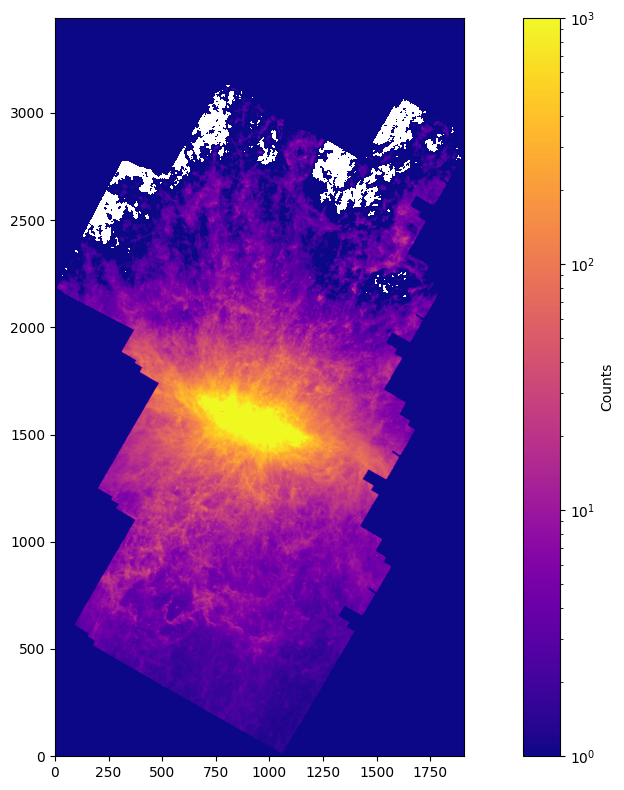

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(imdat,norm=LogNorm(vmin=1, vmax=1000),origin='lower',cmap='plasma')
fig.colorbar(im,label="Counts", orientation="vertical") 
plt.tight_layout()
plt.show()

## Highlighting the Filaments

The next goal is to isolate the filaments from the more diffuse gas surroundings. 

To do this we will use the SourceExtractor Python package "sep". It has a builtin function that removes the background. Normally this is used for images with well defined objects and dark surroundings (think the Hubble deep field) however in this case we simply use it to remove low intensity material

In [4]:
imdat = imdat.byteswap().newbyteorder()
bkg = sep.Background(imdat)
bkgsub = imdat-bkg

Below we can see the lower intensity material was removed leaving behind a sort of skeletal image of the filaments.

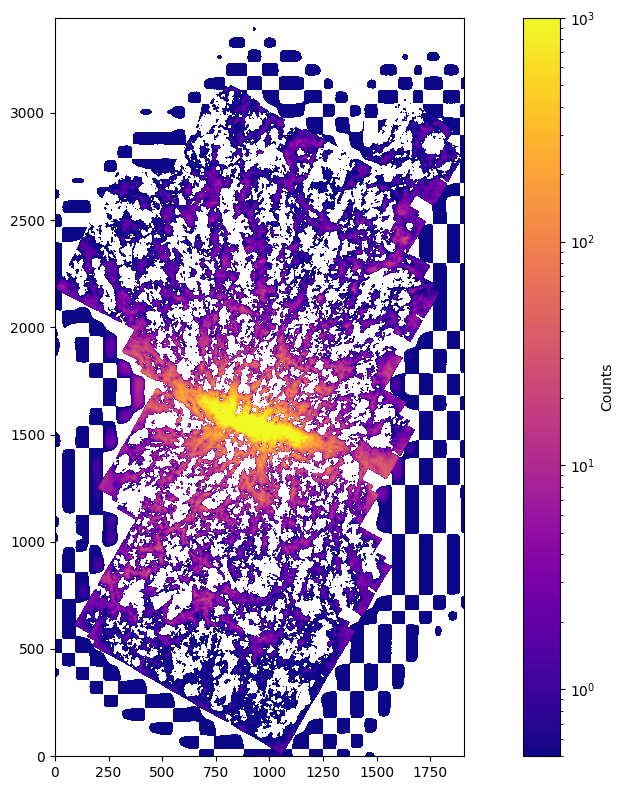

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(bkgsub,norm=LogNorm(vmin=0.5, vmax=1000),origin='lower',cmap='plasma')
fig.colorbar(im,label="Counts", orientation="vertical") 
plt.tight_layout()
plt.show()

While we did well in isolating the low intensity gas, we still have low intensity material. You can see it above in the colors where the colorbar shows values less than 1 ($10^0$)

To get rid of more dim material we will use the sigma_clipped_stats function that finds the median of the array and then subtracts some multiple of it from the whole thing. Right now the sigma parameter is set to 10, this seems to be too high because much of the emission was removed. Try adjusting it until you get the right balance of filaments and dim diffuse material.

In [6]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-01-25T23:25:04.847' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'ngc3034_miri_lv3_f770w_i2d.fits' / Name of the file                  
SDP_VER = '2023_3b '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-064'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '009.001.000.000'    / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC2431 '        

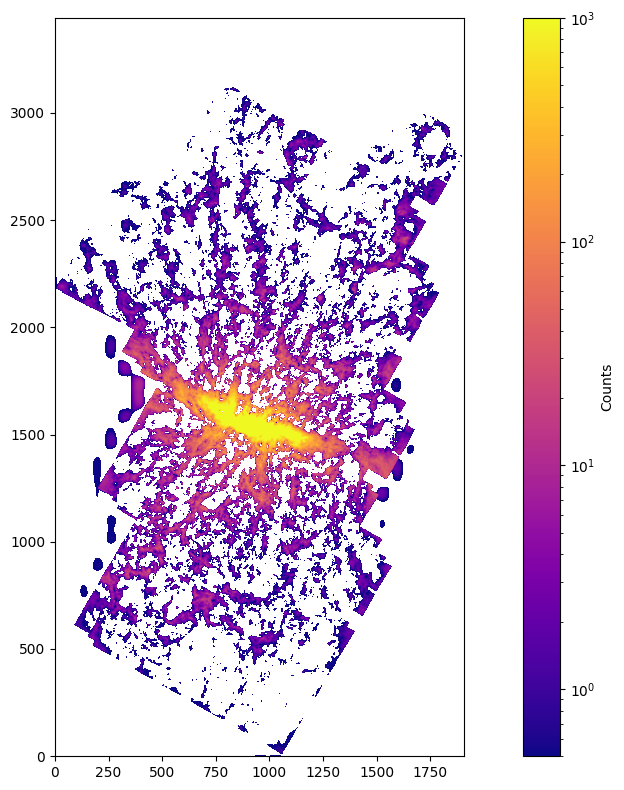

In [9]:
from astropy.stats import sigma_clipped_stats
sig = sigma_clipped_stats(bkgsub, sigma=6)
msig = np.ones(bkgsub.shape)*sig[0]
reduced_image = bkgsub-msig
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(reduced_image,norm=LogNorm(vmin=0.5, vmax=1000),origin='lower',cmap='plasma')
fig.colorbar(im,label="Counts", orientation="vertical") 
plt.tight_layout()
plt.show()

The next few lines will save the image as a new FITS file.

In [10]:
hdu = fits.PrimaryHDU(reduced_image,header=header)
hdu.writeto('M82_JWST_reduced.fits',overwrite=True)

Set OBSGEO-B to    44.633889 from OBSGEO-[XYZ].
Set OBSGEO-H to     2556.989 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
